In [1]:
import numpy as np
import pandas as pd
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py

In [3]:
# from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [4]:
TRAIN_DATA_PATH = '/kaggle/input/nlp-project-dataset/train_split.json'
TEST_DATA_PATH  = '/kaggle/input/nlp-project-dataset/test_split.json'
VAL_DATA_PATH   = '/kaggle/input/nlp-project-dataset/validation_split.json'

In [5]:
def read_json(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data
def set_num_sentence(data):
    num_sentence = 0
    for i in range(len(data)):
        sentences = []
        for j in range(len(data[i]['sentences_containing_the_numeral_in_answer_options'])):
            sentences += [k for k in data[i]['sentences_containing_the_numeral_in_answer_options'][j]]
        data[i]['sentences_containing_the_numeral_in_answer_options'] = sentences
        


In [6]:
TRAIN_DATA = read_json(TRAIN_DATA_PATH)
VALIDATION_DATA = read_json(VAL_DATA_PATH)
TEST_DATA = read_json(TEST_DATA_PATH)

set_num_sentence(TRAIN_DATA)
set_num_sentence(VALIDATION_DATA)
set_num_sentence(TEST_DATA)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
# device = torch.device('xla')

In [9]:
LEARNING_RATE = 0.5
MAX_LEN = 32
BATCH_SIZE = 32
SEQ_LEN = 20
# FOR THE SEQ_LEN = 30, READ THE DATA RETREIVAL FILE

In [10]:
class Chinese_Article_Data(Dataset):
    def __init__(self, file, tokenizer, max_len, seq_len):
        self.data = file
        self.tokenizer = tokenizer
        self.max_len   = max_len
        self.seq_len   = seq_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        news_article_input_ids   = torch.empty((self.seq_len,self.max_len))
        news_article_attention_list = torch.empty((self.seq_len,self.max_len))
        itr = 0
        KEY = 'sentences_containing_the_numeral_in_answer_options'
        for sentence_idx in range(len(self.data[idx][KEY])):
            news_article_instance = self.data[idx][KEY][itr]
            encoding = self.tokenizer.encode_plus (
                news_article_instance, 
                max_length = self.max_len,
                pad_to_max_length = True,
                truncation = True,
                padding = 'max_length',
                return_attention_mask= True,
                return_tensors = 'pt',
            )
            news_article_input_ids[itr] = encoding['input_ids']
            news_article_attention_list[itr]  = encoding['attention_mask']
            itr += 1
            if (itr == self.seq_len):
                break
            
        while(itr < self.seq_len):
            encoding = self.tokenizer.encode_plus (
                'NULL', 
                max_length = self.max_len,
                pad_to_max_length = True,
                truncation = True,
                padding = 'max_length',
                return_attention_mask= True,
                return_tensors = 'pt',
            )
            news_article_input_ids[itr] = encoding['input_ids']
            news_article_attention_list[itr]  = encoding['attention_mask']
            itr += 1
        
        question = self.data[idx]['question_stem']
        encoding = self.tokenizer.encode_plus (
                question, 
                max_length = self.max_len,
                pad_to_max_length = True,
                truncation = True,
                padding = 'max_length',
                return_attention_mask= True,
                return_tensors = 'pt',
            )
        question_input_ids = encoding['input_ids']
        question_attention_mask = encoding['attention_mask']
        
        answer_option = self.data[idx]['answer_options']
        
        answer_option_input_ids = torch.empty((4,32))
        answer_option_attention_mask = torch.empty((4,32))
        
        for opt_idx in range(4):
            option_sentence = self.data[idx]['answer_options'][opt_idx]
            encoding = self.tokenizer.encode_plus (
                option_sentence,
                max_length = 32,
                pad_to_max_length = True,
                truncation = True,
                padding = 'max_length',
                return_attention_mask= True,
                return_tensors = 'pt',
            )
            answer_option_input_ids[opt_idx] = encoding['input_ids']
            answer_option_attention_mask[opt_idx] = encoding['attention_mask']
            
            
        answer   = torch.tensor([1.0 if (x==self.data[idx]['ans']) else 0.0 for x in range(4)])
#         print(itr)
        return news_article_input_ids, news_article_attention_list, question_input_ids, question_attention_mask, answer, answer_option_input_ids,answer_option_attention_mask


In [11]:
def getloader(file = None, tokenizer = tokenizer, max_len = MAX_LEN, batch_size = BATCH_SIZE, seq_len = SEQ_LEN):
    dataset = Chinese_Article_Data (file, tokenizer, max_len,seq_len)
    loader = DataLoader(dataset = dataset, batch_size = batch_size, num_workers = 4, shuffle = False, pin_memory = True)
    return loader

In [12]:
class Chinese_answer_Model(nn.Module):
    def __init__(self):
        super(Chinese_answer_Model, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-chinese", return_dict = True)
        
        self.num_layers = 1
        self.D = 1
        self.hidden_size = 768
        self.option_gru  = nn.GRU(input_size = 768, hidden_size = self.hidden_size, num_layers = self.num_layers, batch_first = False, bidirectional = False)
        
        self.text_gru =  nn.GRU(input_size = 768, hidden_size = self.hidden_size, num_layers = self.num_layers, batch_first = False, bidirectional = False)
        
        self.fc1 = nn.Linear(self.D*self.num_layers*self.hidden_size * 2, 4)
        
    def forward(self, news_article_input_ids, news_article_attention_mask,question_input_ids, question_attention_mask, answer_option_input_ids, answer_option_attention_mask):
        output = torch.empty((news_article_input_ids.shape[0], 4)).to(device)
        
        for i in range(news_article_input_ids.shape[0]):
            text_out = self.bert(input_ids = news_article_input_ids[i].long(),attention_mask= news_article_attention_mask[i])
            question_out = self.bert(input_ids = question_input_ids[i].long(),attention_mask= question_attention_mask[i])
            answer_option_out = self.bert(input_ids = answer_option_input_ids[i].long(), attention_mask = answer_option_attention_mask[i])
            
            question_out = question_out.pooler_output
            answer_option_out = answer_option_out.pooler_output
            text_out = text_out.pooler_output
            
#             question_out = question_out.unsqueeze(1)
            answer_option_out = answer_option_out.unsqueeze(1)
            text_out = text_out.unsqueeze(1)
            
            
            h_0 = torch.empty((self.D* self.num_layers, question_out.size(0),question_out.size(1))).to(device)
            for st in range(self.D * self.num_layers):
                h_0[st] = question_out
                
            _ , hn1 = self.option_gru (text_out, h_0)
            
            _, hn2 = self.text_gru (answer_option_out, hn1)
            
            hn1 = torch.flatten(hn1)
            hn2 = torch.flatten(hn2)
            
            out = torch.cat((hn1,hn2),dim = -1)
            
            out = out.unsqueeze(0)
            
            out = self.fc1(out)
#             print(out,out.shape)
            out = torch.softmax(out, dim = 1)
#             print(out, out.shape)
            output[i]  = out
        
        return output

In [13]:
train_data_loader = getloader(TRAIN_DATA[:5000])
validation_data_loader = getloader(VALIDATION_DATA[:100])
# test_data_loader = getloader(TEST_DATA)

In [14]:
model = Chinese_answer_Model()
model.to(device)
model = nn.DataParallel(model)

In [15]:
import torch.optim.lr_scheduler as lr_scheduler

def loss_fn (outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets)
optimizer = torch.optim.SGD(params = model.parameters(), lr = LEARNING_RATE)
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=LEARNING_RATE, end_factor=0.5, total_iters=5)

In [16]:
EPOCH = 2

In [17]:
def train(data_loader, val_loader):
    train_loss_list = []
    val_loss_list = []
    for epochs in range(EPOCH):
        train_loss = 0
        val_loss = 0
        model.train()
        for batch , data in tqdm(enumerate(data_loader, 0), unit="batch", total=len(data_loader)):
            news_article_input_ids, news_article_attention_mask,question_input_ids, question_attention_mask, answer, answer_option_input_ids, answer_option_attention_mask = data
            news_article_input_ids = news_article_input_ids.to(device)
            news_article_attention_mask = news_article_attention_mask.to(device)
            question_input_ids = question_input_ids.to(device)
            question_attention_mask = question_attention_mask.to(device)
            answer_option_input_ids = answer_option_input_ids.to(device)
            answer_option_attention_mask = answer_option_attention_mask.to(device)
            answer = answer.to(device)
            optimizer.zero_grad()
            outputs = model(news_article_input_ids, news_article_attention_mask,question_input_ids, question_attention_mask, answer_option_input_ids, answer_option_attention_mask)
            loss = loss_fn(outputs, answer)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        
        model.eval()
        with torch.no_grad():
            for batch , data in  tqdm(enumerate(val_loader, 0), unit="batch", total=len(val_loader)):
                news_article_input_ids, news_article_attention_mask,question_input_ids, question_attention_mask, answer, answer_option_input_ids, answer_option_attention_mask = data
                news_article_input_ids = news_article_input_ids.to(device)
                news_article_attention_mask = news_article_attention_mask.to(device)
                question_input_ids = question_input_ids.to(device)
                question_attention_mask = question_attention_mask.to(device)
                answer_option_input_ids = answer_option_input_ids.to(device)
                answer_option_attention_mask = answer_option_attention_mask.to(device)
                answer = answer.to(device)
                outputs = model(news_article_input_ids, news_article_attention_mask,question_input_ids, question_attention_mask, answer_option_input_ids, answer_option_attention_mask)
                loss = loss_fn(outputs, answer)
                val_loss += loss.item()
#             before_lr = optimizer.param_groups[0]["lr"]
#             scheduler.step()
#             after_lr = optimizer.param_groups[0]["lr"] 
                
        print(f"[{epochs+1}/{EPOCH}], Training Loss: {train_loss/len(data_loader)} Validation_loss: {val_loss/len(val_loader)}")
#         torch.save(model.module.state_dict(), f'Rishav_NLP_R1_number_sentence-checkpoint-{epochs+1}.pth')
        train_loss_list.append(train_loss/len(data_loader))
        val_loss_list.append(val_loss/len(val_loader))
    return train_loss_list, val_loss_list

In [18]:
trainLoss, valLoss = train(train_data_loader, validation_data_loader)

100%|██████████| 4/4 [00:03<00:00,  1.12batch/s]

[1/2], Training Loss: 1.4291752462933778 Validation_loss: 1.384293258190155



100%|██████████| 4/4 [00:03<00:00,  1.20batch/s]

[2/2], Training Loss: 1.4301729999530088 Validation_loss: 1.3842932879924774


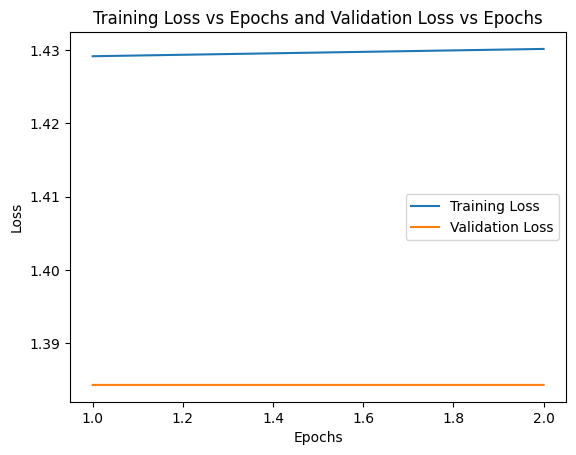

In [19]:
import matplotlib.pyplot as plt
epochs = [x for x in range(1, EPOCH+ 1)]
plt.plot(epochs, trainLoss, label='Training Loss')
plt.plot(epochs, valLoss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs and Validation Loss vs Epochs')
plt.legend()
plt.show()



In [20]:
# torch.save(model.module.state_dict(), 'Rishav_NLP_R1_number_sentence.pth')

In [21]:
import numpy as np
import pandas as pd
import transformers
import torch
import torch.optim
from transformers import BertModel, BertTokenizer
from torch import nn
import json
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

LEARNING_RATE = 5e-2
MAX_LEN = 32
BATCH_SIZE = 16
SEQ_LEN = 20
# FOR THE SEQ_LEN = 20, READ THE DATA RETREIVAL FILE

from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')


def read_json(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data
def set_num_sentence(data):
    num_sentence = 0
    for i in range(len(data)):
        sentences = []
        for j in range(len(data[i]['sentences_containing_the_numeral_in_answer_options'])):
            sentences += [k for k in data[i]['sentences_containing_the_numeral_in_answer_options'][j]]
        data[i]['sentences_containing_the_numeral_in_answer_options'] = sentences

class Chinese_answer_Model(nn.Module):
    def __init__(self):
        super(Chinese_answer_Model, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-chinese", return_dict = True)
        
        self.num_layers = 1
        self.D = 1
        self.hidden_size = 768
        self.option_gru  = nn.GRU(input_size = 768, hidden_size = self.hidden_size, num_layers = self.num_layers, batch_first = False, bidirectional = False)
        
        self.text_gru =  nn.GRU(input_size = 768, hidden_size = self.hidden_size, num_layers = self.num_layers, batch_first = False, bidirectional = False)
        
        self.fc1 = nn.Linear(self.D*self.num_layers*self.hidden_size * 2, 4)
        
    def forward(self, news_article_input_ids, news_article_attention_mask,question_input_ids, question_attention_mask, answer_option_input_ids, answer_option_attention_mask):
        output = torch.empty((news_article_input_ids.shape[0], 4)).to(device)
        
        for i in range(news_article_input_ids.shape[0]):
            text_out = self.bert(input_ids = news_article_input_ids[i].long(),attention_mask= news_article_attention_mask[i])
            question_out = self.bert(input_ids = question_input_ids[i].long(),attention_mask= question_attention_mask[i])
            answer_option_out = self.bert(input_ids = answer_option_input_ids[i].long(), attention_mask = answer_option_attention_mask[i])
            
            question_out = question_out.pooler_output
            answer_option_out = answer_option_out.pooler_output
            text_out = text_out.pooler_output
            
#             question_out = question_out.unsqueeze(1)
            answer_option_out = answer_option_out.unsqueeze(1)
            text_out = text_out.unsqueeze(1)
            
            
            h_0 = torch.empty((self.D* self.num_layers, question_out.size(0),question_out.size(1))).to(device)
            for st in range(self.D * self.num_layers):
                h_0[st] = question_out
                
            _ , hn1 = self.option_gru (text_out, h_0)
            
            _, hn2 = self.text_gru (answer_option_out, hn1)
            
            hn1 = torch.flatten(hn1)
            hn2 = torch.flatten(hn2)
            
            out = torch.cat((hn1,hn2),dim = -1)
            
            out = out.unsqueeze(0)
            
            out = self.fc1(out)
            out = torch.softmax(out, dim = 1)
            
            output[i]  = out
        
        return output
class Chinese_Article_Data(Dataset):
    def __init__(self, file, tokenizer, max_len, seq_len):
        self.data = file
        self.tokenizer = tokenizer
        self.max_len   = max_len
        self.seq_len   = seq_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        news_article_input_ids   = torch.empty((self.seq_len,self.max_len))
        news_article_attention_list = torch.empty((self.seq_len,self.max_len))
        itr = 0
        KEY = 'sentences_containing_the_numeral_in_answer_options'
        for sentence_idx in range(len(self.data[idx][KEY])):
            news_article_instance = self.data[idx][KEY][itr]
            encoding = self.tokenizer.encode_plus (
                news_article_instance, 
                max_length = self.max_len,
                pad_to_max_length = True,
                truncation = True,
                padding = 'max_length',
                return_attention_mask= True,
                return_tensors = 'pt',
            )
            news_article_input_ids[itr] = encoding['input_ids']
            news_article_attention_list[itr]  = encoding['attention_mask']
            itr += 1
            if (itr == self.seq_len):
                break
            
        while(itr < self.seq_len):
            encoding = self.tokenizer.encode_plus (
                'NULL', 
                max_length = self.max_len,
                pad_to_max_length = True,
                truncation = True,
                padding = 'max_length',
                return_attention_mask= True,
                return_tensors = 'pt',
            )
            news_article_input_ids[itr] = encoding['input_ids']
            news_article_attention_list[itr]  = encoding['attention_mask']
            itr += 1
        
        question = self.data[idx]['question_stem']
        encoding = self.tokenizer.encode_plus (
                question, 
                max_length = self.max_len,
                pad_to_max_length = True,
                truncation = True,
                padding = 'max_length',
                return_attention_mask= True,
                return_tensors = 'pt',
            )
        question_input_ids = encoding['input_ids']
        question_attention_mask = encoding['attention_mask']
        
        answer_option = self.data[idx]['answer_options']
        
        answer_option_input_ids = torch.empty((4,32))
        answer_option_attention_mask = torch.empty((4,32))
        
        for opt_idx in range(4):
            option_sentence = self.data[idx]['answer_options'][opt_idx]
            encoding = self.tokenizer.encode_plus (
                option_sentence,
                max_length = 32,
                pad_to_max_length = True,
                truncation = True,
                padding = 'max_length',
                return_attention_mask= True,
                return_tensors = 'pt',
            )
            answer_option_input_ids[opt_idx] = encoding['input_ids']
            answer_option_attention_mask[opt_idx] = encoding['attention_mask']
            
            
        answer   = torch.tensor([1.0 if (x==self.data[idx]['ans']) else 0.0 for x in range(4)])
        print(answer)
#         print(itr)
        return news_article_input_ids, news_article_attention_list, question_input_ids, question_attention_mask, answer, answer_option_input_ids,answer_option_attention_mask


def getloader(file = None, tokenizer = tokenizer, max_len = MAX_LEN, batch_size = BATCH_SIZE, seq_len = SEQ_LEN):
    dataset = Chinese_Article_Data (file, tokenizer, max_len,seq_len)
    loader = DataLoader(dataset = dataset, batch_size = batch_size, num_workers = 4, shuffle = False, pin_memory = True)
    return loader

    

# defining the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





from sklearn.metrics import f1_score, accuracy_score,  classification_report
def evaluate(file_path,model):
    # give the loaded file
    file  = read_json(file_path)
    set_num_sentence(file)
    file = file[:100]
    data = getloader(file)
    
    num_correct = 0
    num_wrong= 0
    for batch, d in tqdm(enumerate(data, 0), unit="batch", total=len(data)):

        
        news_article_input_ids, news_article_attention_mask,question_input_ids, question_attention_mask, answer, answer_option_input_ids, answer_option_attention_mask = d
        news_article_input_ids = news_article_input_ids.to(device)
        news_article_attention_mask = news_article_attention_mask.to(device)
        question_input_ids = question_input_ids.to(device)
        question_attention_mask = question_attention_mask.to(device)
        answer_option_input_ids = answer_option_input_ids.to(device)
        answer_option_attention_mask = answer_option_attention_mask.to(device)
        answer = answer.to(device)
        outputs = model(news_article_input_ids, news_article_attention_mask,question_input_ids, question_attention_mask, answer_option_input_ids, answer_option_attention_mask)
        
        print(outputs)
        
        target_indices = torch.argmax(answer, dim=1)
        prediction_indices = torch.argmax(outputs, dim=1)

        # Compare the indices to find correct and wrong predictions
        num_correct += torch.sum(target_indices == prediction_indices).item()
        num_wrong += torch.sum(target_indices != prediction_indices).item()
    
    print (f"Accuracy : {num_correct/(num_correct+num_wrong)}")

load_model = Chinese_answer_Model()
# Load the state_dict
load_model.load_state_dict(torch.load('/kaggle/working/Rishav_NLP_R1_number_sentence-checkpoint-2.pth'))
load_model.to(device)
load_model = nn.DataParallel(load_model)
file_path = "/kaggle/input/nlp-project-dataset/validation_split.json"
evaluate(file_path, load_model)

tensor([1., 0., 0., 0.])tensor([1., 0., 0., 0.])

  0%|          | 0/7 [00:00<?, ?batch/s]



tensor([1., 0., 0., 0.])tensor([0., 0., 1., 0.])

tensor([0., 1., 0., 0.])
tensor([0., 0., 0., 1.])
tensor([0., 0., 0., 1.])tensor([0., 1., 0., 0.])

tensor([0., 0., 1., 0.])
tensor([0., 0., 0., 1.])
tensor([1., 0., 0., 0.])tensor([0., 0., 0., 1.])

tensor([0., 0., 0., 1.])
tensor([0., 0., 0., 1.])tensor([0., 1., 0., 0.])tensor([1., 0., 0., 0.])


tensor([0., 0., 0., 1.])tensor([0., 0., 1., 0.])

tensor([0., 0., 0., 1.])
tensor([0., 0., 1., 0.])tensor([0., 1., 0., 0.])
tensor([0., 0., 0., 1.])

tensor([0., 1., 0., 0.])tensor([0., 1., 0., 0.])

tensor([0., 1., 0., 0.])tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([1., 0., 0., 0.])

tensor([0., 0., 1., 0.])tensor([1., 0., 0., 0.])
tensor([0., 0., 0., 1.])

tensor([0., 1., 0., 0.])tensor([1., 0., 0., 0.])
tensor([0., 0., 1., 0.])

tensor([0., 0., 0., 1.])
tensor([0., 0., 0., 1.])
tensor([0., 1., 0., 0.])tensor([0., 0., 1., 0.])tensor([0., 1., 0., 0.])

tensor([0., 1., 0., 0.])

tensor([1., 0., 0., 0.])

tensor([0., 1., 0., 0.

 14%|█▍        | 1/7 [00:01<00:07,  1.20s/batch]

tensor([[0.0379, 0.3556, 0.5491, 0.0574],
        [0.0375, 0.3583, 0.5467, 0.0575],
        [0.0371, 0.3599, 0.5458, 0.0572],
        [0.0399, 0.3624, 0.5372, 0.0605],
        [0.0387, 0.3589, 0.5440, 0.0584],
        [0.0371, 0.3609, 0.5451, 0.0569],
        [0.0436, 0.3156, 0.5786, 0.0621],
        [0.0377, 0.3608, 0.5445, 0.0570],
        [0.0371, 0.3311, 0.5735, 0.0583],
        [0.0367, 0.3540, 0.5522, 0.0571],
        [0.0374, 0.3695, 0.5365, 0.0566],
        [0.0371, 0.3632, 0.5424, 0.0572],
        [0.0376, 0.3605, 0.5445, 0.0574],
        [0.0372, 0.3632, 0.5441, 0.0555],
        [0.0370, 0.3676, 0.5391, 0.0563],
        [0.0374, 0.3697, 0.5372, 0.0558]], device='cuda:0',
       grad_fn=<GatherBackward>)


 29%|██▊       | 2/7 [00:01<00:04,  1.12batch/s]

tensor([[0.0365, 0.3550, 0.5511, 0.0574],
        [0.0370, 0.3672, 0.5398, 0.0560],
        [0.0362, 0.3559, 0.5523, 0.0556],
        [0.0398, 0.3766, 0.5271, 0.0565],
        [0.0411, 0.3681, 0.5320, 0.0587],
        [0.0394, 0.3746, 0.5302, 0.0558],
        [0.0383, 0.3843, 0.5222, 0.0552],
        [0.0401, 0.3674, 0.5371, 0.0555],
        [0.0368, 0.3591, 0.5475, 0.0566],
        [0.0386, 0.3556, 0.5473, 0.0586],
        [0.0409, 0.3712, 0.5301, 0.0578],
        [0.0368, 0.3556, 0.5501, 0.0575],
        [0.0365, 0.3566, 0.5511, 0.0557],
        [0.0387, 0.3784, 0.5268, 0.0561],
        [0.0369, 0.3611, 0.5460, 0.0560],
        [0.0369, 0.3548, 0.5512, 0.0570]], device='cuda:0',
       grad_fn=<GatherBackward>)


 43%|████▎     | 3/7 [00:02<00:03,  1.32batch/s]

tensor([[0.0388, 0.3733, 0.5297, 0.0583],
        [0.0385, 0.3776, 0.5272, 0.0568],
        [0.0370, 0.3508, 0.5551, 0.0571],
        [0.0379, 0.3730, 0.5337, 0.0554],
        [0.0362, 0.3492, 0.5576, 0.0571],
        [0.0377, 0.3671, 0.5388, 0.0563],
        [0.0369, 0.3539, 0.5526, 0.0566],
        [0.0372, 0.3649, 0.5414, 0.0565],
        [0.0368, 0.3504, 0.5547, 0.0580],
        [0.0374, 0.3660, 0.5409, 0.0557],
        [0.0366, 0.3500, 0.5567, 0.0567],
        [0.0369, 0.3703, 0.5367, 0.0560],
        [0.0393, 0.3821, 0.5222, 0.0564],
        [0.0365, 0.3610, 0.5467, 0.0559],
        [0.0389, 0.3768, 0.5278, 0.0565],
        [0.0384, 0.3743, 0.5310, 0.0563]], device='cuda:0',
       grad_fn=<GatherBackward>)


 57%|█████▋    | 4/7 [00:03<00:02,  1.43batch/s]

tensor([[0.0375, 0.3656, 0.5406, 0.0564],
        [0.0382, 0.3500, 0.5537, 0.0582],
        [0.0366, 0.3639, 0.5441, 0.0554],
        [0.0405, 0.2682, 0.6299, 0.0615],
        [0.0391, 0.3542, 0.5477, 0.0590],
        [0.0376, 0.3774, 0.5294, 0.0556],
        [0.0369, 0.3629, 0.5445, 0.0557],
        [0.0368, 0.3527, 0.5526, 0.0579],
        [0.0367, 0.3625, 0.5444, 0.0564],
        [0.0391, 0.3723, 0.5300, 0.0586],
        [0.0389, 0.3742, 0.5303, 0.0566],
        [0.0371, 0.3559, 0.5499, 0.0571],
        [0.0376, 0.3530, 0.5518, 0.0576],
        [0.0373, 0.3603, 0.5458, 0.0567],
        [0.0392, 0.3430, 0.5586, 0.0592],
        [0.0391, 0.3740, 0.5296, 0.0574]], device='cuda:0',
       grad_fn=<GatherBackward>)


 71%|███████▏  | 5/7 [00:03<00:01,  1.55batch/s]

tensor([[0.0388, 0.3586, 0.5417, 0.0610],
        [0.0364, 0.3611, 0.5456, 0.0569],
        [0.0372, 0.3460, 0.5587, 0.0582],
        [0.0377, 0.3583, 0.5470, 0.0571],
        [0.0368, 0.3544, 0.5512, 0.0576],
        [0.0364, 0.3432, 0.5636, 0.0569],
        [0.0374, 0.3555, 0.5505, 0.0567],
        [0.0371, 0.3530, 0.5531, 0.0569],
        [0.0366, 0.3688, 0.5389, 0.0557],
        [0.0368, 0.3650, 0.5425, 0.0557],
        [0.0358, 0.2833, 0.6169, 0.0639],
        [0.0386, 0.3663, 0.5391, 0.0560],
        [0.0374, 0.3584, 0.5459, 0.0583],
        [0.0372, 0.3395, 0.5655, 0.0577],
        [0.0367, 0.3614, 0.5450, 0.0569],
        [0.0392, 0.3827, 0.5224, 0.0557]], device='cuda:0',
       grad_fn=<GatherBackward>)


 86%|████████▌ | 6/7 [00:04<00:00,  1.63batch/s]

tensor([[0.0365, 0.3579, 0.5496, 0.0560],
        [0.0362, 0.3624, 0.5458, 0.0557],
        [0.0375, 0.3809, 0.5268, 0.0548],
        [0.0390, 0.3719, 0.5319, 0.0573],
        [0.0371, 0.3557, 0.5497, 0.0575],
        [0.0390, 0.3535, 0.5489, 0.0586],
        [0.0392, 0.2981, 0.6014, 0.0614],
        [0.0378, 0.3584, 0.5449, 0.0589],
        [0.0382, 0.3095, 0.5910, 0.0614],
        [0.0406, 0.3768, 0.5257, 0.0569],
        [0.0374, 0.3739, 0.5329, 0.0558],
        [0.0367, 0.3506, 0.5561, 0.0565],
        [0.0410, 0.3420, 0.5566, 0.0604],
        [0.0409, 0.3814, 0.5215, 0.0561],
        [0.0382, 0.3729, 0.5321, 0.0568],
        [0.0416, 0.3405, 0.5571, 0.0608]], device='cuda:0',
       grad_fn=<GatherBackward>)


100%|██████████| 7/7 [00:04<00:00,  1.55batch/s]

tensor([[0.0388, 0.3729, 0.5294, 0.0590],
        [0.0369, 0.3681, 0.5396, 0.0553],
        [0.0366, 0.3616, 0.5456, 0.0562],
        [0.0366, 0.3545, 0.5518, 0.0572]], device='cuda:0',
       grad_fn=<GatherBackward>)
Accuracy : 0.25
